In [1]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('medium_posts.csv')
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [2]:
df['published_date'] = pd.to_datetime(df['published']).dt.date
df.head()

,published,domain,url,published_date
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...,2012-08-13
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...,2012-08-13
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...,2016-11-04
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...,2016-12-24
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...,2015-09-22


In [3]:
df_by_day = df['published_date'].value_counts().sort_index()
df_by_day

1970-01-01      2
1970-01-18      3
2003-09-14      1
2004-04-04      1
2004-04-16      1
             ... 
2017-06-23    421
2017-06-24    277
2017-06-25    253
2017-06-26    207
2017-06-27     36
Name: published_date, Length: 1738, dtype: int64

In [4]:
df_by_day = df_by_day.iloc[2:]
df_by_day.head()

2003-09-14    1
2004-04-04    1
2004-04-16    1
2005-09-12    1
2006-02-19    1
Name: published_date, dtype: int64

In [5]:
df_by_day = df_by_day.to_frame()
df_by_day['ds'] = df_by_day.index

In [6]:
df_by_day.rename(columns={"published_date":"y"}, inplace=True)

In [7]:
df_by_day.head()

,y,ds
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16
2005-09-12,1,2005-09-12
2006-02-19,1,2006-02-19


In [8]:
m = Prophet()
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future.tail()

07:04:13 - cmdstanpy - INFO - Chain [1] start processing
07:04:13 - cmdstanpy - INFO - Chain [1] done processing


,ds
2096,2018-06-23
2097,2018-06-24
2098,2018-06-25
2099,2018-06-26
2100,2018-06-27


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2096,2018-06-23,417.643198,388.524240,448.490604
2097,2018-06-24,419.165458,387.922557,449.914802
2098,2018-06-25,445.453038,413.986900,473.394096
2099,2018-06-26,446.517992,417.890246,476.621711
2100,2018-06-27,447.282035,417.243902,478.204439


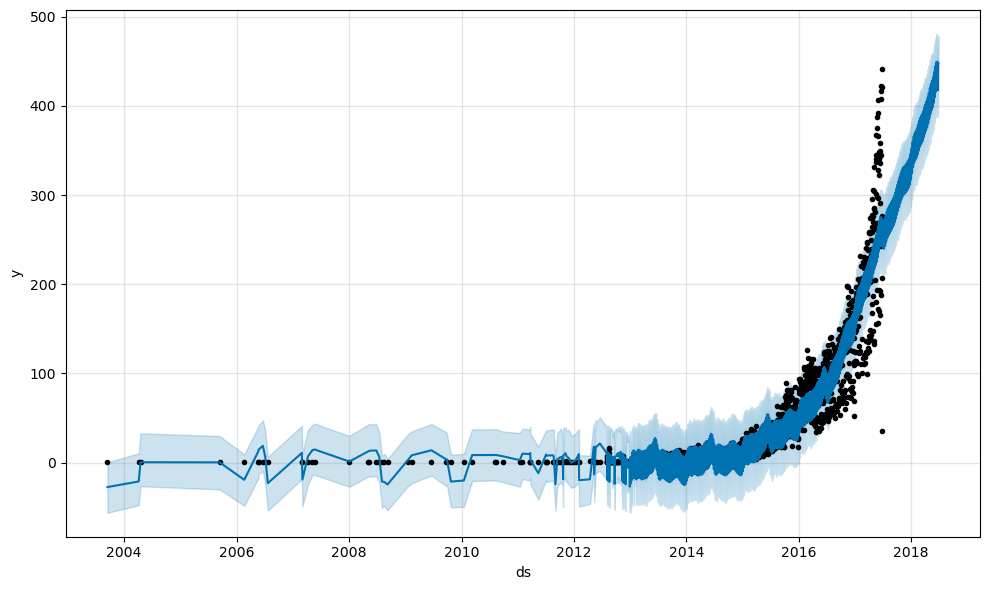

In [10]:
fig1 = m.plot(forecast)

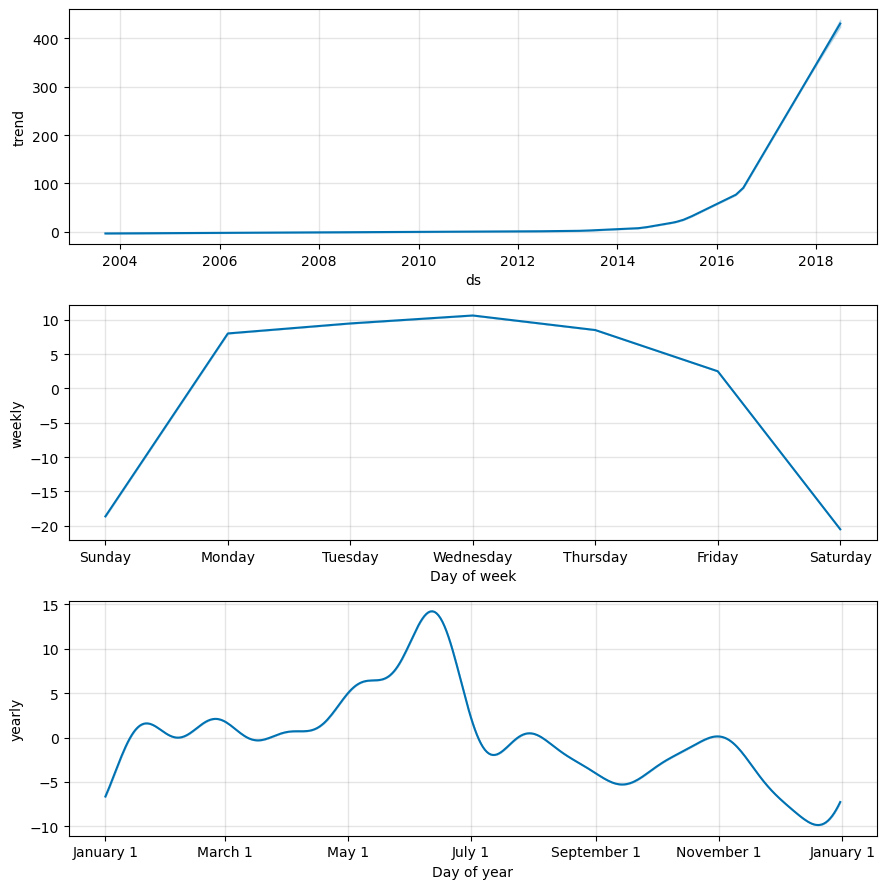

In [11]:
fig2 = m.plot_components(forecast)

In [12]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

  0%|          | 0/22 [00:00<?, ?it/s]

07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
07:04:16 - cmdstanpy - INFO - Chain [1] start processing
07:04:16 - cmdstanpy - INFO - Chain [1] done processing
07:04:16 - cmdstanpy - INFO - Chain [1] start processing
07:04:16 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2006-05-22,1.0,1.0,1.0,1,2006-02-20
1,2006-05-23,1.0,1.0,1.0,1,2006-02-20
2,2006-06-20,1.0,1.0,1.0,1,2006-02-20
3,2006-07-06,1.0,1.0,1.0,1,2006-02-20
4,2006-07-22,1.0,1.0,1.0,1,2006-02-20


In [13]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,40 days,143.533346,11.980540,7.379880,0.355212,0.268886,0.373707,0.491152
1,41 days,148.165784,12.172337,7.432732,0.349104,0.267790,0.370572,0.501511
2,42 days,151.902328,12.324866,7.440108,0.349303,0.263778,0.368299,0.510574
3,43 days,150.048804,12.249441,7.372480,0.347940,0.263778,0.366005,0.514890
4,44 days,146.535586,12.105188,7.291083,0.346397,0.264278,0.365489,0.518343


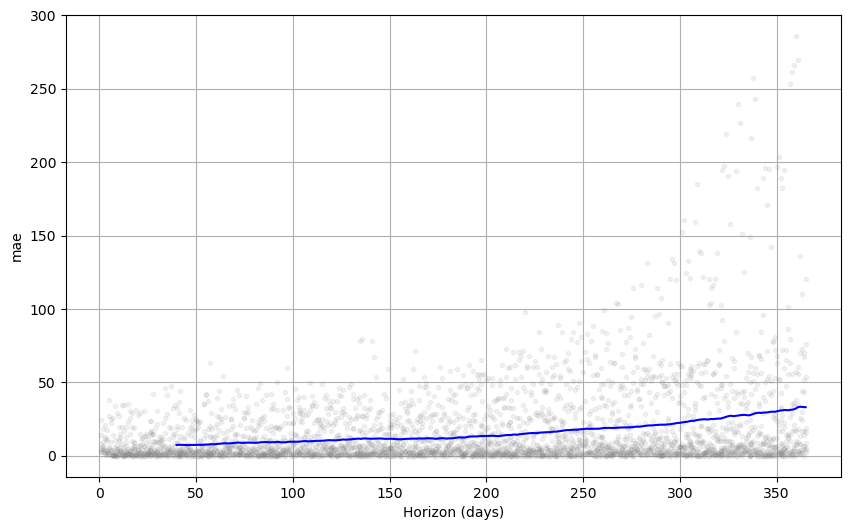

In [14]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [19]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_by_day)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
print(tuning_results)

10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] done processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] done processing
10:35:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] done processing
10:35:29 - cmdstanpy - INFO - Chain [1] start processing
10:35:29 - cmdstanpy - INFO - Chain [1] done processing
10:35:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:29

10:35:34 - cmdstanpy - INFO - Chain [1] done processing
10:35:34 - cmdstanpy - INFO - Chain [1] done processing
10:35:34 - cmdstanpy - INFO - Chain [1] done processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] start processing
10:35:34 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] start processing
10:35:35 - cmdstanpy - INFO - Chain [1] done processing
10:35:35 - cmdstanpy - INFO - Chain [1] st

10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] done processing
10:35:40 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] done processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] done processing
10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:41 - cmdstanpy - INFO - Chain [1] done processing
10:35:41 - cmdstanpy - INFO - Chain [1] st

Optimization terminated abnormally. Falling back to Newton.
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] start processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] done processing
10:35:46 - cmdstanpy - INFO - Chain [1] done pro

10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:53 - cmdstanpy - INFO - Chain [1] done processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] done processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] done processing
10:35:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processing
10:35:54 - cmdstanpy - INFO - Chain [1] start processi

10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1] done processing
10:36:00 - cmdstanpy - INFO - Chain [1

10:36:06 - cmdstanpy - INFO - Chain [1] start processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] start processing
10:36:06 - cmdstanpy - INFO - Chain [1] start processing
10:36:06 - cmdstanpy - INFO - Chain [1] start processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:06 - cmdstanpy - INFO - Chain [1] done processing
10:36:07 - cmdstanpy - INFO - Chain [1] done processing
10:36:07 - cmdstanpy - INFO - Chain [1] start processing
10:36:07 - cmdstanpy - INFO - Chain [1] done processing
10:36:07 - cmdstanpy - INFO - Chain [1] start processing
10:36:07 - cmdstanpy - INFO - Chain [1] st

10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] done processing
10:36:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
Optimization terminated abnormally. Falling back to Newton.
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] done processing
10:36:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] done processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] start processing
10:36:1

10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] start processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:21 - cmdstanpy - INFO - Chain [1] done processing
10:36:22 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] 

10:36:30 - cmdstanpy - INFO - Chain [1] done processing
10:36:30 - cmdstanpy - INFO - Chain [1] done processing
10:36:30 - cmdstanpy - INFO - Chain [1] done processing
10:36:30 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing
10:36:31 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] 

10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processin

10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] start processing
10:36:42 - cmdstanpy - INFO - Chain [1] done processing
10:36:42 - cmdstanpy - INFO - Chain [1] done process

10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] done processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:56 - cmdstanpy - INFO - Chain [1] start processing
10:36:57 - cmdstanpy - INFO - Chain [1] done processing
10:36:57 - cmdstanpy - INFO - Chain [

10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing
10:37:22 - cmdstanpy - INFO - Chain [1] done processing
10:37:22 - cmdstanpy - INFO - Chain [1

10:37:43 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [1] done processing
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
10:37:44 - cmdstanpy - INFO - Chain [

10:38:05 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] start processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [1] done processing
10:38:11 - cmdstanpy - INFO - Chain [

10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:30 - cmdstanpy - INFO - Chain [1] done processing
10:38:30 - cmdstanpy - INFO - Chain [

Optimization terminated abnormally. Falling back to Newton.
10:38:46 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] start processing
10:38:52 - cmdstanpy - INFO - Chain [1] done processing
10:38:52 - cmdstanpy - INFO - Cha

10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:08 - cmdstanpy - INFO - Chain [1] done processing
10:39:09 - cmdstanpy - INFO - Chain [1] done processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] done processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] done processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] start processing
10:39:09 - cmdstanpy - INFO - Chain [1] done processing
10:39:09 - cmdstanpy - INFO - Chain [1] s

10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] start processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] done processing
10:39:37 - cmdstanpy - INFO - Chain [1] s

10:40:01 - cmdstanpy - INFO - Chain [1] done processing
10:40:01 - cmdstanpy - INFO - Chain [1] done processing
10:40:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:40:01 - cmdstanpy - INFO - Chain [1] done processing
10:40:01 - cmdstanpy - INFO - Chain [1] start processing
10:40:01 - cmdstanpy - INFO - Chain [1] done processing
10:40:01 - cmdstanpy - INFO - Chain [1] done processing
10:40:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:40:01 - cmdstanpy - INFO - Chain [1] start processing
10:40:03 - cmdstanpy - INFO - Chain [1] done processing
10:40:05 - cmdstanpy - INFO - Chain [1] done processing
10:40:05 - cmdstanpy - INFO - Chain [1] start processing
10:40:05 - cmdstanpy - INFO - Chain [1] done processing
10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:06 - c

10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing
10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:29 - cmdstanpy - INFO - Chain [1] done processing
10:40:29 - cmdstanpy - INFO - Chain [1] s

10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton

10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] start processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] done processing
10:41:09 - cmdstanpy - INFO - Chain [1] s

10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
10:41:16 - cmdstanpy - INFO - Chain [1]

10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] s

10:41:30 - cmdstanpy - INFO - Chain [1] done processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] done processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:30 - cmdstanpy - INFO - Chain [1] start processing
10:41:31 - cmdstanpy - INFO - Chain [1] start processing
10:41:31 - cmdstanpy - INFO - Chain [1] done processing
10:41:31 - cmdstanpy - INFO - Chain [1] start processing
10:41:31 - cmdstanpy - INFO - Chain [1] start processing
10:41:31 - cmdstanpy - INFO - Chain [1] start processing
10:41:31 - cmdstanpy - INFO - Chain [1] done processing
10:41:31 - cmdstanpy - INFO - Chain [1] done processing
10:41:31 - cmdstanpy - INFO - Chain [1] done processing
10:41:31 - cmdstanpy - INFO - Chain [1] done processing
10:41:31 - cmdstanpy - INFO - Chain [1

10:41:37 - cmdstanpy - INFO - Chain [1] start processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] start processing
10:41:38 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - INFO - Chain [1] done processing
10:41:38 - cmdstanpy - INFO - Chain [1] st

10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] done processing
10:41:45 - cmdstanpy - INFO - Chain [1] start processing
10:41:46 - cmdstanpy - INFO - Chain [1] d

10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] done processing
10:41:52 - cmdstanpy - INFO - Chain [1] start processing
10:41:52 - cmdstanpy - INFO - Chain [

10:41:59 - cmdstanpy - INFO - Chain [1] start processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] start processing
10:41:59 - cmdstanpy - INFO - Chain [1] start processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] done processing
10:41:59 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] done processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] start processing
10:42:00 - cmdstanpy - INFO - Chain [1] 

10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] start processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:06 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1] done processing
10:42:07 - cmdstanpy - INFO - Chain [1]

10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:14 - cmdstanpy - INFO - Chain [1] done processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1]

10:42:22 - cmdstanpy - INFO - Chain [1] start processing
10:42:22 - cmdstanpy - INFO - Chain [1] start processing
10:42:22 - cmdstanpy - INFO - Chain [1] start processing
10:42:22 - cmdstanpy - INFO - Chain [1] start processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] start processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:22 - cmdstanpy - INFO - Chain [1] done processing
10:42:23 - cmdstanpy - INFO - Chain [1] start processing
10:42:23 - cmdstanpy - INFO - Chain [1] done processing
10:42:23 - cmdstanpy - INFO - Chain [1] start processing
10:42:23 - cmdstanpy - INFO - Chain [1] s

10:42:31 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] start processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [1] done processing
10:42:32 - cmdstanpy - INFO - Chain [

10:42:40 - cmdstanpy - INFO - Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] s

10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] done processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] done processing
10:42:50 - cmdstanpy - INFO - Chain [1] done processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] done processing
10:42:51 - cmdstanpy - INFO - Chain [1] s

10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing
10:43:00 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing
10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1

10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] done processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] start processing
10:43:11 - cmdstanpy - INFO - Chain [1] 

10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1] done processing
10:43:21 - cmdstanpy - INFO - Chain [1

10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] s

10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] done processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:40 - cmdstanpy - INFO - Chain [1] start processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] done processing
10:43:41 - cmdstanpy - INFO - Chain [1] start processing
10:43:42 - cmdstanpy - INFO - Chain [1] done processing
10:43:42 - cmdstanpy - INFO - Chain [1] s

10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:52 - cmdstanpy - INFO - Chain [1] start processing
10:43:52 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [1] done processing
10:43:53 - cmdstanpy - INFO - Chain [

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.10   
..                       ...                      ...                   ...   
251                    0.500                    10.00                  1.00   
252                    0.500                    10.00                 10.00   
253                    0.500                    10.00                 10.00   
254                    0.500                    10.00                 10.00   
255                    0.500                    10.00                 10.00   

    seasonality_mode  changepoint_range       rmse 

In [25]:
tuning_results.sort_values('mae').head(40)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mae
198,0.5,0.01,0.10,multiplicative,0.80,27.723428,13.362756
194,0.5,0.01,0.01,multiplicative,0.80,27.723428,13.362756
202,0.5,0.01,1.00,multiplicative,0.80,27.723428,13.362756
206,0.5,0.01,10.00,multiplicative,0.80,27.723428,13.362756
223,0.5,0.10,10.00,multiplicative,0.95,28.537553,13.978967
219,0.5,0.10,1.00,multiplicative,0.95,28.537553,13.978967
211,0.5,0.10,0.01,multiplicative,0.95,28.537553,13.978967
215,0.5,0.10,0.10,multiplicative,0.95,28.537553,13.978967
231,0.5,1.00,0.10,multiplicative,0.95,28.668496,14.227942
227,0.5,1.00,0.01,multiplicative,0.95,28.668496,14.227942
